# Base System Tutorial: Make your own model

In this tutorial, we will show you how to make your own model using the ComFiT library.

We will look at two examples, one with a scalar order parameter, and one with a vector order parameter.

## Scalar order parameter

We will start with a simple example of a scalar order parameter $\psi$, which will follow the following equation of motion

$$
\partial_t \psi = \nabla^2 \psi - \texttt{r} \psi - \psi^3,
$$

where $\texttt{r}$ is a parameter. 
For more information on what exactly this equation of motion represents, details are given later in this document.

We see that we can write this equation on the form 

$$
\partial_t \psi = \omega (\nabla) \psi + N, 
$$

where $\omega$ is a linear operator acting on $\psi$

$$
\omega (\nabla) = \nabla^2 - r
$$

and $N$ is a non-linear operator

$$
N = -\psi^3.
$$

Both of these pieces need to be implemented in ComFiT to run the simulation. 

We start by making a class for our specific system that inherits from the `BaseSystem` class. We will call it `LandauSystem`.

In [1]:
import sys
from pathlib import Path
current_dir = Path().resolve()
parent_dir = current_dir.parent
sys.path.append(str(parent_dir))
import comfit as cf

class LandauSystem(cf.BaseSystem):
    
    def __init__(self,dim, r, **kwargs):
        self.r = r
        super().__init__(dim, **kwargs)
        

This will create a class inheriting from `BaseSystem` which uses the same initialization as the `BaseSystem` class, but also sets the `r` parameter. 

In [2]:
ls = LandauSystem(2, 0.5)
print(ls.r)

0.5


Now, we want to add our linear operator. 
We will return the linear operator in Fourier space, calc_omega_f`, and in order to calculate the Laplacian, we will use the predefined function `calc_k2`, which exists in `BaseSystem`, to do so. 
If you find this part confusing, we recommend going through the [Basic Framework Tutorial](https://colab.research.google.com/github/vidarsko/ComFiT/blob/main/tutorial/base_system_basic_framework.ipynb). 
We will also calculate the nonlinear function. 

Due to the way the computational setup works, both functions need to be returned in Fourier space, which is why we use the subscript `_f` in them, and we will use the `fft.fftn` function from `scipy` to do so.

In [3]:
import scipy as sp

# Make linear operator
def calc_omega_f(self):
    return -self.calc_k2() - self.r

# Add method to class
LandauSystem.calc_omega_f = calc_omega_f

# Make the non-linear operator
def calc_nonlinear_evolution_function_f(self, field, t):
    return -sp.fft.fftn(field**3)

# Add method to class
LandauSystem.calc_nonlinear_evolution_function_f = calc_nonlinear_evolution_function_f

Next, we will configure the solver of the system 

In [4]:
import numpy as np
def evolve(self, number_steps):
    omega_f = calc_omega_f(self)

    integrating_factors_f, solver = self.calc_integrating_factors_f_and_solver(omega_f, 'ETD2RK')

    for n in range(number_steps):
        self.psi, self.psi_f = solver(integrating_factors_f, 
                                    self.calc_nonlinear_evolution_function_f, 
                                    self.psi, self.psi_f)
        self.psi = np.real(self.psi)

# Add evolve method to class
LandauSystem.evolve = evolve

The system is now ready to run, but we need to define the initial condition.
Since both `psi` and `psi_f` are needed to run the simulation, we will need to define both these quantities. 

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x/a_0$', ylabel='$y/a_0$'>)

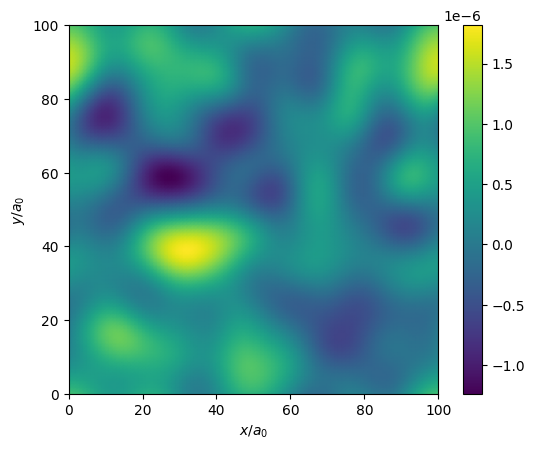

In [5]:
# Initiating a system with positive r value
ls = LandauSystem(2, 0.5)

# Setting an initial condition with both positive and negative values
ls.psi = np.random.rand(ls.xRes,ls.yRes)-0.5
ls.psi_f = sp.fft.fftn(ls.psi)

# Evolving the system
ls.evolve(200)
ls.plot_field(ls.psi)

The field is approaches zero everywhere. 
Lets modify the value of $r$. 

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='$x/a_0$', ylabel='$y/a_0$'>)

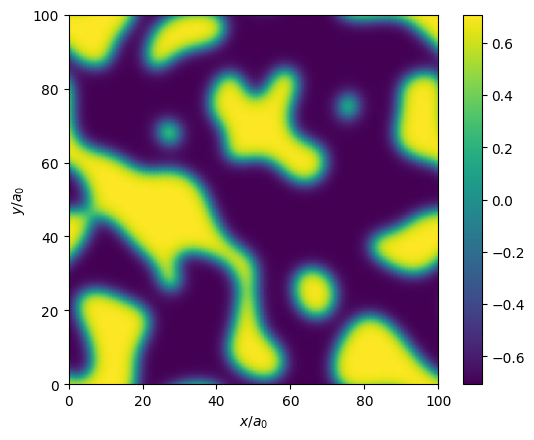

In [6]:
# Initiating a system with a postive r value
ls = LandauSystem(2, -0.5)

# Setting an initial condition with both positive and negative values
ls.psi = np.random.rand(ls.xRes,ls.yRes)-0.5
ls.psi_f = sp.fft.fftn(ls.psi)

# Evolving the systemm
ls.evolve(200)
ls.plot_field(ls.psi)

To illustrate what is happening, we will create two animations, showing the evolution in both cases. 

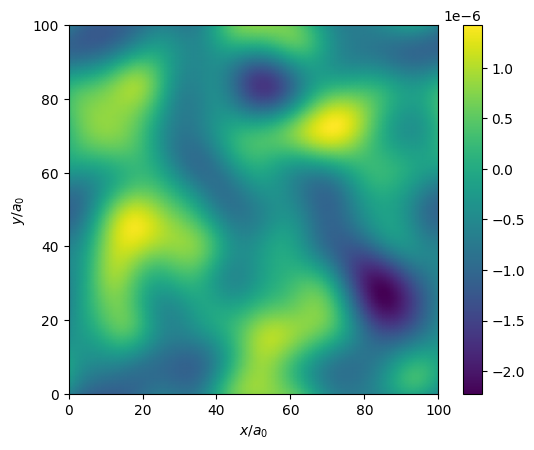

In [7]:
# Initiating a system with positive r value
ls = LandauSystem(2, 0.5)

# Setting an initial condition with both positive and negative values
ls.psi = np.random.rand(ls.xRes,ls.yRes)-0.5
ls.psi_f = sp.fft.fftn(ls.psi)

# Make animation
for n in range(100):
    ls.evolve(2)
    ls.plot_field(ls.psi)
    cf.tool_save_plot(n)
cf.tool_make_animation_gif(n,name='evolution_positive_r')

The plot above just shows the last plot while the animation is saved in the folder containing this notebook.


Now let's do the same for $r<0$

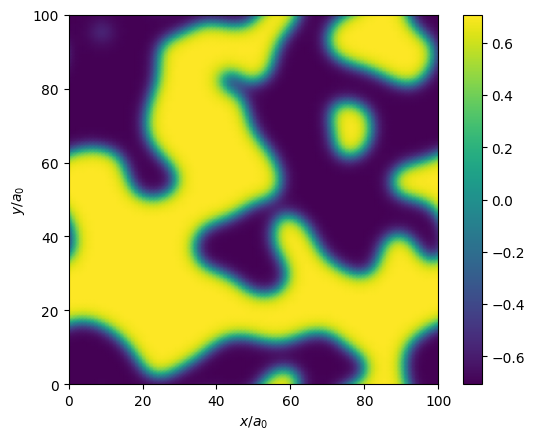

In [8]:
# Initiating a system with negative r value
ls = LandauSystem(2, -0.5)

# Setting an initial condition with both positive and negative values
ls.psi = np.random.rand(ls.xRes,ls.yRes)-0.5
ls.psi_f = sp.fft.fftn(ls.psi)

# Make animation
for n in range(100):
    ls.evolve(2)
    ls.plot_field(ls.psi)
    cf.tool_save_plot(n)
cf.tool_make_animation_gif(n,name='evolution_negative_r')

It is easy now to produce similar results for one and three dimensions. 

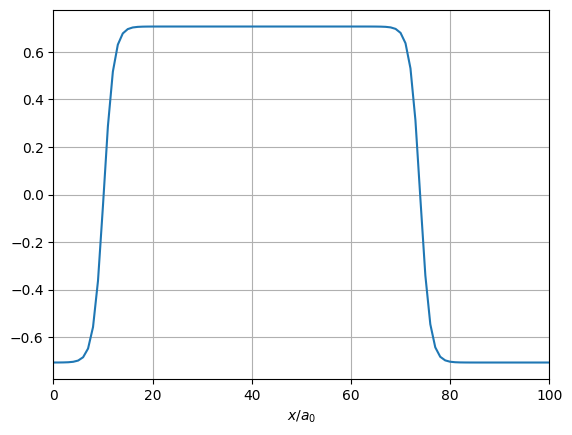

In [9]:
# Initiating a system with negative r value
ls = LandauSystem(1, -0.5)

# Setting an initial condition with both positive and negative values
ls.psi = np.random.rand(ls.xRes)-0.5
ls.psi_f = sp.fft.fftn(ls.psi)

# Make animation
for n in range(100):
    ls.evolve(3)
    ls.plot_field(ls.psi)
    cf.tool_save_plot(n)
cf.tool_make_animation_gif(n,name='evolution_1D_negative_r')

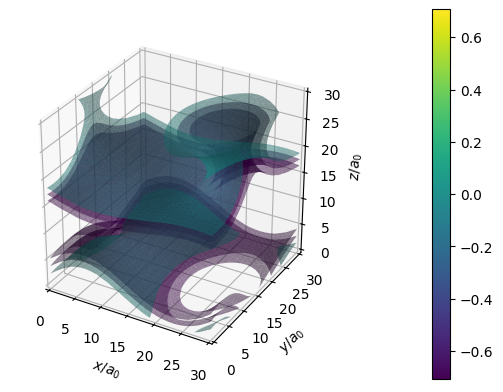

In [11]:
# Initiating a system with negative r value
# Decreasing the resolution a bit for faster computation
ls = LandauSystem(3, -0.5, xRes=31, yRes=31, zRes=31)

# Setting an initial condition with both positive and negative values
ls.psi = np.random.rand(ls.xRes,ls.yRes,ls.zRes)-0.5
ls.psi_f = sp.fft.fftn(ls.psi)

# Make animation
for n in range(100):
    ls.evolve(3)
    ls.plot_field(ls.psi)
    cf.tool_save_plot(n)
cf.tool_make_animation_gif(n,name='evolution_3D_negative_r')

### Why do we see a phase-transition at this value?

The equation of motion is derived from a simple version of Landau theory of the Bragg-Williams theory. 
In this case, the primary field variable is a scalar field $\psi$ for which the complete field energy is

$$
\mathcal F[\psi] = \int d\boldsymbol{r} \frac{1}{2} (\nabla \psi)^2  + \frac{1}{2} \texttt r \psi^2 + \frac{1}{4} \psi^4  .
$$

A dynamical equation which minimizes this functions is given by. 

$$
\partial_t \psi = - \frac{\delta \mathcal F}{\delta \psi} = \nabla^2 \psi - r \psi - \psi^3
$$

which we have solved numerically in the code example above. 
Here, we will look at why we get at phase transition at $r=0$.

Due to the first term, a minimal free energy state is given by a uniform state $\psi(\mathbf r) = \psi_0$, for which the free energy is 

$$
F = V \left( \frac{1}{2} \texttt r \psi_0^2 + \frac{1}{4} \psi_0^4 \right) .
$$

To find the equilibrium value of $\psi_0$, we differentiate wrt. $\psi_0$ and set to zero, obtaining

$$
r\psi_0 + \psi_0^3 = 0 .
$$

which has solutions $\psi_0 = 0$ and $\psi_0 = \pm \sqrt{-r}$. 
At $r>0$, only the first solution exists, whereas at $r<0$, both solutions exist and the latter is energetically favorable (smaller $F$), as can be verified by insertion. 
Therefore, we expect a phase transition at $r=0$, as we observe.